In [1]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
import numpy as np
import email
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
spam_cat = 1
ham_cat = 0
vocab_size = 2500

In [3]:
def get_message_text(eml_file_path):
    with open(eml_file_path, 'r') as file:
        try:
            message = email.message_from_file(file)
        except:
            return 'no_decode'
        if message.is_multipart():
            for part in message.walk():
                # Если письмо многочастное, обрабатываем каждую его часть
                if part.get_content_type() == 'text/plain':
                    try: 
                        return part.get_payload(decode=True).decode()
                    except:
                        return 'no_decode'
        else:
            try:
                return message.get_payload(decode=True).decode()
            except:
                return 'no_decode'

In [15]:
# spam_emails:
df_spam = pd.DataFrame(columns=['DocId','message','category'])
folder_path_spam = r'c:\temp\spam'  # Укажите путь к папке с файлами .eml
# ham_emails
df_ham = pd.DataFrame({'DocId':[],'message':[],'category':[]})
folder_path_ham = r'c:\temp\ham_mail'  # Укажите путь к папке с файлами .eml

In [17]:
for file_name in tqdm(os.listdir(folder_path_spam)):
    if file_name.endswith(".eml"):
        file_path = os.path.join(folder_path_spam, file_name)
        message_text = get_message_text(file_path)
        row = {'DocId':file_name, 'message':message_text, 'category':1}
        df_spam = pd.concat([df_spam, pd.DataFrame.from_records([row])], 
                            axis=0, ignore_index=True)
        # df_spam = df_spam.append({'DocId':file_name, 'message':message_text, 'category':1}, ignore_index=True) 

100%|███████████████████████████████████████████████████████████████████████████████| 374/374 [00:01<00:00, 227.97it/s]


In [18]:
for file_name in tqdm(os.listdir(folder_path_ham)):
    if file_name.endswith(".eml"):
        file_path = os.path.join(folder_path_ham, file_name)
        message_text = get_message_text(file_path)
        row = {'DocId':file_name, 'message':message_text, 'category':0}
        df_ham = pd.concat([df_ham, pd.DataFrame.from_records([row])], 
                            axis=0, ignore_index=True)

        # df_ham = df_ham.append({'DocId':file_name, 'message':message_text, 'category':0}, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:30<00:00, 32.75it/s]


In [19]:
data = pd.concat([df_spam, df_ham])
data['DocId'] = [i for i in range(len(data))]
data = data.astype({'DocId':'int64','category':'int64','message':'str'})
data = data.set_index('DocId')

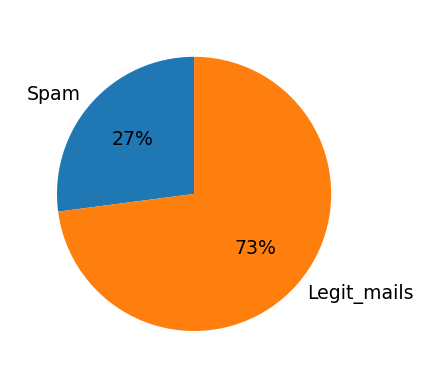

In [21]:
amount_of_spam = data.category.value_counts()[1]
amount_of_ham = data.category.value_counts()[0]

category_names = ['Spam', 'Legit_mails']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90, autopct='%1.0f%%')
plt.show()

In [22]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words())):
    if message is not None or type(message) == 'NoneType':
        #REMOVE HTML TAGS
        soup = BeautifulSoup(message, 'html.parser')
        cleanned_text = soup.get_text()

        #converts to lower words
        words = word_tokenize(cleanned_text.lower())
        filtered_words = []

        for word in words:
            if word not in stop_words and word.isalpha():
                filtered_words.append(stemmer.stem(word))

        return filtered_words
    else:
        return ['None', 'Type']

In [23]:
stemmed_nested_list = data.message.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [24]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('uniq_words is ', unique_words.shape[0])
unique_words.head()

uniq_words is  7363


http     3891
link     1690
imag     1110
полис     364
العمل     320
dtype: int64

In [25]:
vocab_size = unique_words.shape[0]
word_ids = list(range(0, vocab_size))
vocab = pd.DataFrame({'VOCAB_WORD': unique_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
word_list = list(vocab['VOCAB_WORD'])
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,link
2,imag
3,полис
4,العمل


In [26]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9352,9353,9354,9355,9356,9357,9358,9359,9360,9361
0,interest,real,protect,safer,safer,smarter,home,http,smart,flexibl,...,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,protect,home,pest,summer,save,pest,control,plan,free,estim,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [27]:
# Splitting the datainto a Training and Testing dataset
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.category, test_size=0.3)

In [29]:
# Create a Sparse matrix for the Training data

def make_sparse_matrix(df, list_words, labels):
    
    # Return a sparse matrix as dataframe
    # df - a dataframe with words in the columns with a document id as an index (X_train or X_test)
    # indexed_words - indexed of words by word id
    # labels - category as a series (y_train or y_test)
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    
    dict_list = []
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i, j]
            if word in list_words:
                doc_id = df.index[i]
                word_id = list_words.index(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [30]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_list, y_train)

CPU times: total: 39min 20s
Wall time: 42min 25s


In [31]:
sparse_train_df.shape

(51345, 4)

In [32]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,1,356,1,384
1,1,356,1,669
2,1,356,1,3993
3,1,356,1,64
4,1,356,1,1167


In [35]:
# Combine Occurence with the Pandas groupby() method

train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,3
1,0,10,1,1
2,0,18,1,3
3,0,42,1,1
4,0,45,1,1


In [36]:
sparse_train_data = train_grouped.to_numpy()

In [40]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_list, y_test)

CPU times: total: 13min 51s
Wall time: 14min 4s


In [41]:
sparse_test_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,1221,1,110
1,0,1221,1,2
2,0,1221,1,0
3,0,1221,1,1
4,0,1221,1,0


In [42]:
# Combine Occurence with the Pandas groupby() method

test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,5,0,1,3
1,5,10,1,1
2,5,18,1,3
3,5,42,1,1
4,5,45,1,1


In [43]:
sparse_test_data = test_grouped.to_numpy()

In [53]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx=0, word_idx=1, cat_idx=2, freq_idx=3):
    """
    From a full_matrix from a sparce_matrix return pandas DataFrame.
    keyword arguments:
    sparse_matrix -- numpy array.
    nr_words -- size a vocabulary. Total number of tokens.
    doc_idx -- position of the document id in the sparce_matrix. Default - 1st column.
    word_idx -- position of the word id in the sparce_matrix. Default - 2st column.
    cat_idx -- position of the label (spam 1 /nospam 0). Default - 3st column.
    freq_idx -- position of occurence of word in sparce_matrix. Default - 4st column.
    """
    column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0, vocab_size))
    doc_id_names = np.unique(sparse_matrix[:, 0])
    full_matrix = pd.DataFrame(index=doc_id_names, columns=column_names)
    full_matrix.fillna(value=0, inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr, 'DOC_ID'] = doc_nr
        full_matrix.at[doc_nr, 'CATEGORY'] = label
        full_matrix.at[doc_nr, word_id] = occurence
    
    full_matrix.set_index('DOC_ID', inplace=True)
    return full_matrix

In [54]:
%%time
full_train_data = make_full_matrix(sparse_train_data, vocab_size)

CPU times: total: 5 s
Wall time: 5.13 s


In [55]:
full_train_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
full_train_data.reset_index().to_excel(r'c:\temp\full_matrix\full_train_data.xlsx',encoding='Windows-1251',index=False)

In [56]:
%%time
full_test_data = make_full_matrix(sparse_test_data, vocab_size)

CPU times: total: 3.27 s
Wall time: 3.55 s


In [57]:
full_test_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,1,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
full_test_data.reset_index().to_excel(r'c:\temp\full_matrix\full_test_data.xlsx',encoding='Windows-1251',index=False)

In [ ]:
# calculate probability

In [67]:
full_train_data.CATEGORY.size   # count all emails

515

In [68]:
full_train_data.CATEGORY.sum()  # count spam emails

203

In [69]:
prob_spam = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size
print('Probability of spam is ', prob_spam)

Probability of spam is  0.3941747572815534


In [70]:
# Total number of words/Tokens

full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
email_lengths = full_train_features.sum(axis=1)
email_lengths.shape

(515,)

In [72]:
email_lengths[:5]

DOC_ID
0     50
3     62
7     62
8     64
14     9
dtype: int64

In [73]:
total_wc = email_lengths.sum()
total_wc

51345

In [ ]:
# Number of tokens in spam & ham emails

In [74]:
spam_lengths = email_lengths[full_train_data.CATEGORY == 1]
spam_lengths.shape

(203,)

In [76]:
spam_wc = spam_lengths.sum()
spam_wc

28331

In [77]:
ham_lengths = email_lengths[full_train_data.CATEGORY == 0]
ham_lengths.shape

(312,)

In [78]:
nonspam_wc = ham_lengths.sum()
nonspam_wc

23014

In [ ]:
# summing tokens occuring in spam

In [79]:
full_train_features.shape

(515, 7363)

In [81]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY == 1]
train_spam_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
train_spam_tokens.tail()

,0,1,2,3,4,5,6,7,8,9,...,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362
DOC_ID,,,,,,,,,,,,,,,,,,,,,
362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
summed_spam_tokens = train_spam_tokens.sum(axis=0) + 1
summed_spam_tokens.shape

(7363,)

In [84]:
summed_spam_tokens

0       344
1        17
2        23
3         1
4         1
       ... 
7358      1
7359      1
7360      1
7361      1
7362      2
Length: 7363, dtype: int64

In [ ]:
# summing tokens occuring in ham

In [85]:
train_ham_tokens = full_train_features.loc[full_train_data.CATEGORY == 0]
train_ham_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362
DOC_ID,,,,,,,,,,,,,,,,,,,,,
374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
376,9,0,0,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
379,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
380,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
summed_ham_tokens = train_ham_tokens.sum(axis=0) + 1
summed_ham_tokens.shape

(7363,)

In [87]:
summed_ham_tokens

0       2263
1       1106
2        716
3        245
4          1
        ... 
7358       1
7359       1
7360       1
7361       1
7362       1
Length: 7363, dtype: int64

In [ ]:
# P(Token|Spam) - Probability that a Token Occurs given the Emails is Spam

In [102]:
prob_tokens_spam = summed_spam_tokens / (spam_wc + vocab_size)
prob_tokens_spam[:5]

0    0.009637
1    0.000476
2    0.000644
3    0.000028
4    0.000028
dtype: float64

In [103]:
prob_tokens_spam.sum()

1.0

In [ ]:
# P(Token|Ham) - Probability that a Token Occurs given the Emails is Ham

In [107]:
prob_tokens_nonspam = summed_ham_tokens / (nonspam_wc + vocab_size)
prob_tokens_nonspam[:5]

0    0.074497
1    0.036409
2    0.023570
3    0.008065
4    0.000033
dtype: float64

In [109]:
prob_tokens_nonspam.sum()

1.0

In [ ]:
# P(Token) - Probability that Token Occurs

In [110]:
prob_token_all = full_train_features.sum(axis=0) / total_wc
prob_token_all

0       0.050735
1       0.021833
2       0.014354
3       0.004752
4       0.000000
          ...   
7358    0.000000
7359    0.000000
7360    0.000000
7361    0.000000
7362    0.000019
Length: 7363, dtype: float64

In [111]:
# Features
X_test = full_test_data.drop(columns=['CATEGORY']).to_numpy()
# Target
y_test = full_test_data.CATEGORY

In [112]:
X_test.shape

(229, 7363)

In [113]:
full_test_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,1,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Calculating the Joint Probability

# P(Spam|X) = P(X|Spam)*P(Spam) / P(X)

In [114]:
prob_spam

0.3941747572815534

In [115]:
np.log(prob_tokens_spam)

0       -4.642096
1       -7.649525
2       -7.347244
3      -10.482738
4      -10.482738
          ...    
7358   -10.482738
7359   -10.482738
7360   -10.482738
7361   -10.482738
7362    -9.789591
Length: 7363, dtype: float64

In [ ]:
# Join probability in log format

In [126]:
X_test.dot(prob_tokens_spam / prob_token_all) * prob_spam

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [134]:
joint_log_spam = X_test.dot(np.log(prob_tokens_spam) - np.log(prob_token_all)) + np.log(prob_spam)

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [135]:
joint_log_spam[:100]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
# P(Spam|X) = P(X|Spam)*(1 - P(Spam)) / P(X)

In [137]:
joint_log_ham = X_test.dot(np.log(prob_tokens_nonspam) - np.log(prob_token_all)) + np.log(1 - prob_spam)

In [138]:
joint_log_ham

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
# Making Predictions

In [139]:
prediction = joint_log_spam > joint_log_ham

In [140]:
prediction[-5:]*1

array([0, 0, 0, 0, 0])

In [141]:
y_test[-5:]

DOC_ID
1354    0
1358    0
1366    0
1367    0
1373    0
Name: CATEGORY, dtype: int64

In [ ]:
# Metrics
# Accuracy

In [142]:
correct_docs = (y_test == prediction).sum()
print('correct_docs is ', correct_docs)
numdocs_wrong = X_test.shape[0] - correct_docs
print('numdocs_wrong is ', numdocs_wrong)

correct_docs is  136
numdocs_wrong is  93


In [143]:
# Accuracy
correct_docs/len(X_test)

0.5938864628820961

In [ ]:
fraction_wrong = numdocs_wrong/len(X_test)
